In [1]:


# Imports
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
import time
from IPython import display
import sys

In [2]:
# Constants
# PHYSICAL PARAMETERS

Mj      = 8.93e22 #  kg      Io mass
Rj      = 1.82e6 #  m      Io radius
G       = 6.67e-11 #  Gravitational constant in SI units

# SIMULATION PARAMETERS
Ninit   = 10000 # Number of particles (if new object is created)
m       = Mj/Ninit # SPH particle mass 
dt      = 100 # Time step size
offset = 0#1.5e6
moon_ratio = 0.1

ball_size = Rj / (np.cbrt(Ninit) * np.sqrt(2))
print(ball_size)


59734.20070303784


In [4]:
# Functions for generating animation states:
# Includes initial states for moon and comet, collision detection and gravity,
# and a function for updating states (frames in animation)

def init_IO(n):
    
    init_state = [np.zeros([6])]
    
    while len(init_state) < n:
        if len(init_state) % 100 == 0:
            print(len(init_state))
            
        tmp_state = np.zeros([6])
        tmp_state[:3] = (np.random.rand(3) - 0.5) * Rj * 2
        
        vec = (tmp_state - init_state)
        vec = vec[:,0:3]
        distance = np.sqrt(vec[:,0] ** 2 + vec[:,1] ** 2 + vec[:,2] ** 2)  
        
        if distance[0] > Rj * 1.05:
            continue
        
        if any(np.where((distance < 2 * ball_size))[0]):
            continue
            
        init_state.append(tmp_state)
        
    
    return np.array(init_state)

def init_comet(state, offset=0, moon_ratio=0.1):
    
    state = list(state)
    state.append([0, 7e7, offset, 0, -1e6, 0])

    while len(state) < int(Ninit + Ninit * moon_ratio):
        if len(state) % 100 == 0:
            print(len(state))

        tmp_state = [0, 7e7, offset, 0, -1e6, 0]
        tmp_state[:3] += (np.random.randn(3) - 0.5) * Rj #* 6 * moon_ratio
        
        vec = (tmp_state - np.array(state)[Ninit:])
        vec = vec[:,0:3]
        distance = np.sqrt(vec[:,0] ** 2 + vec[:,1] ** 2 + vec[:,2] ** 2)  
        
        if distance[0] > Rj * moon_ratio * 6:
            #print('too far away')
            continue
        
        if any(np.where((distance < 2 * ball_size))[0]):
            #print('too close to other ball')
            continue
            
        state.append(tmp_state)
        
    return np.array(state)



def new_state(state, Fi, distances):
    
    a = Fi / m
    
    if any(np.where((distances < 2 * ball_size) & (distances > 0))[0]):

        updates = np.where((distances < 2 * ball_size) & (distances > 0))
        to_be_updated = updates[0]
        updated_with = updates[1]
        state_updates = state[updated_with]        

        for i in range(0,len(to_be_updated)):
            #state[to_be_updated[i]][3:] = state_updates[i] * 0.999
            if to_be_updated[i] >= Ninit:
                state[to_be_updated[i]], s = collision(state[to_be_updated[i]], state_updates[i], 1)
            else: 
                state[to_be_updated[i]], s = collision(state[to_be_updated[i]], state_updates[i], 0.999)
            state[to_be_updated[i]][3:] -= a[to_be_updated[i]] * dt
    
    
    state[:,3:] += a * dt
    state[:,0:3] += state[:,3:]
    
    return state

    
    
def gravity_n_body(state):
    
    Fi = []
    distances = []

    for i in range(0, len(state)):
        
        vec = (state[i] - state)#np.delete(state, i, axis=0))
        vec = vec[:,0:3]
        distance = np.sqrt(vec[:,0] ** 2 + vec[:,1] ** 2 + vec[:,2] ** 2)  
        distances.append(distance)
        #print(vec)
        #print((vec.transpose()/distance**3).transpose())
        Fi.append(np.sum(- G * m ** 2 * np.nan_to_num(vec.transpose()/distance**3).transpose(), axis = 0))
        Fi_max = - G * m ** 2 * 10 * ball_size / ball_size**3
        
        if len(np.where((abs(np.array(Fi)[-1]) > abs(Fi_max)))[0]) > 0:
            
            for i in np.where((abs(np.array(Fi)[-1]) > abs(Fi_max)))[0]:
                if Fi[-1][i] > 0:
                    Fi[-1][i] = Fi_max
                else:
                    Fi[-1][i] = -Fi_max
            #print(abs(np.array(Fi)[-1]))
            #print(abs(Fi_max))
            #print(np.where((abs(np.array(Fi)[-1]) > abs(Fi_max)))[0])
            
            #break
        
    return np.array(Fi), np.array(distances)


def collision(state1, state2, inelasticity=1):
    """
    tmp_state = np.array([state1[3:], state2[3:]])

    state1[3:] = tmp_state[1] * inelasticity
    state2[3:] = tmp_state[0] * inelasticity

    """
    state_diff = state1[0:3] - state2[0:3]
    #print(state_diff)
    n = np.nan_to_num(state_diff / len_vec(state_diff))
    #print(n, len_vec(n))
    
    v_rel = state1[3:] - state2[3:]
    #print(v_rel)
    v_norm = np.dot(v_rel, n) * n
    #print(v_norm)
    
    state1[3:] = (state1[3:] - v_norm) * inelasticity
    state2[3:] = (state2[3:] + v_norm) * inelasticity
    #state1[:3] = state2[:3] + n * ball_size
    
    return state1, state2


    
def len_vec(vec):
    
    return np.sqrt(np.sum([i ** 2 for i in vec]))
    


In [5]:
# generate IO and comet


start_state = init_IO(n=Ninit)
print('done generating IO')

start_state = init_comet(start_state, offset=offset, moon_ratio=moon_ratio)
print('done generating comet')

100
100
100
100
100
200
200
200
200
300
300
300
400
400
500
600
600
600
700
700
800
900
1000
1100
1100
1100
1100
1100
1100
1200
1200
1300
1300
1300
1300
1300
1300
1300
1400
1400
1500
1500
1500
1500
1500
1600
1600
1600
1700
1800
1800
1800
1800
1900
1900
1900
1900
1900
1900
2000
2000
2000
2000
2000
2000
2000
2000
2100
2200
2200
2200
2200
2200
2200
2300
2400
2500
2500
2600
2700
2700
2700
2800
2900
3000
3000
3000
3000
3000
3100
3100
3100
3200
3200
3300
3400
3400
3400
3500
3500
3500
3500
3500
3500
3500
3500
3500
3600
3700
3800
3800
3800
3800
3800
3800
3800
3800
3900
4000
4100
4100
4100
4100
4100
4100
4100
4100
4100
4100
4100
4100
4100
4100
4200
4200
4300
4300
4400
4400
4400
4400
4400
4400
4400
4500
4500
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4600
4700
4700
4700
4700
4700
4700
4700
4700
4700
4700
4700
4700
4700
4700
4700
4700
4700
4700
4700
4700
4700
4700
4700
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4800
4900
5000
5000
5000
5000
5000
5000
5000
5000
5000
51

9400
9400
9400
9400
9400
9400
9400
9400
9400
9400
9400
9400
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500
9500


9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800
9800


10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10300
10400
10400
10400
10400
10400
10400
10400
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10500
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
10600
1060

In [6]:
# create plot states

# This parameter makes the simulation non physical if True, but makes the moon leave its position instead of blowing up
knock_out_of_orbit = False

N = 1500 # animation frames
state = start_state
states = []
for i in range(0,N):
    
    if i % 10 == 0:
        print('calculating state', i)
    #print(state)
    Fi, distances = gravity_n_body(state)

    state = new_state(state, Fi, distances)
    
    if knock_out_of_orbit:

        if  75 > i > 70:
            state[:,1] -= 2e4 * (i - 70)
            #state[:,2] -= 6e3 * (i - 70)

        if i > 74:
            state[:,1] -= 1e5
            #state[:,2] -= 3e4
        
    #print(state, '\n')
    states.append(np.array(state))
    #print(states)
    #print('--------------')
    


calculating state 0


C:\Users\mikkel\Anaconda3\lib\site-packages\ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in true_divide


calculating state 10
calculating state 20
calculating state 30
calculating state 40
calculating state 50
calculating state 60
calculating state 70
calculating state 80
calculating state 90
calculating state 100
calculating state 110
calculating state 120
calculating state 130
calculating state 140
calculating state 150
calculating state 160
calculating state 170
calculating state 180
calculating state 190
calculating state 200
calculating state 210
calculating state 220
calculating state 230
calculating state 240
calculating state 250
calculating state 260
calculating state 270
calculating state 280
calculating state 290
calculating state 300
calculating state 310
calculating state 320
calculating state 330
calculating state 340
calculating state 350
calculating state 360
calculating state 370
calculating state 380
calculating state 390
calculating state 400
calculating state 410
calculating state 420
calculating state 430
calculating state 440
calculating state 450
calculating state 4

In [7]:
np.save('n=10000IOcrash_1500Frames_realistic', states)

In [8]:

# load states and generate distances
states = np.load('n=10000IOcrash_1500Frames_realistic.npy')

distances = []

for i in range(0,len(states[0])):
    vec = (states[0][i] - states[0])#np.delete(state, i, axis=0))
    vec = vec[:,0:3]
    distance = np.sqrt(vec[:,0] ** 2 + vec[:,1] ** 2 + vec[:,2] ** 2)  
    distances.append(distance[0])
    

colors = distances
colors[Ninit:] = np.zeros([len(distances[Ninit:])])


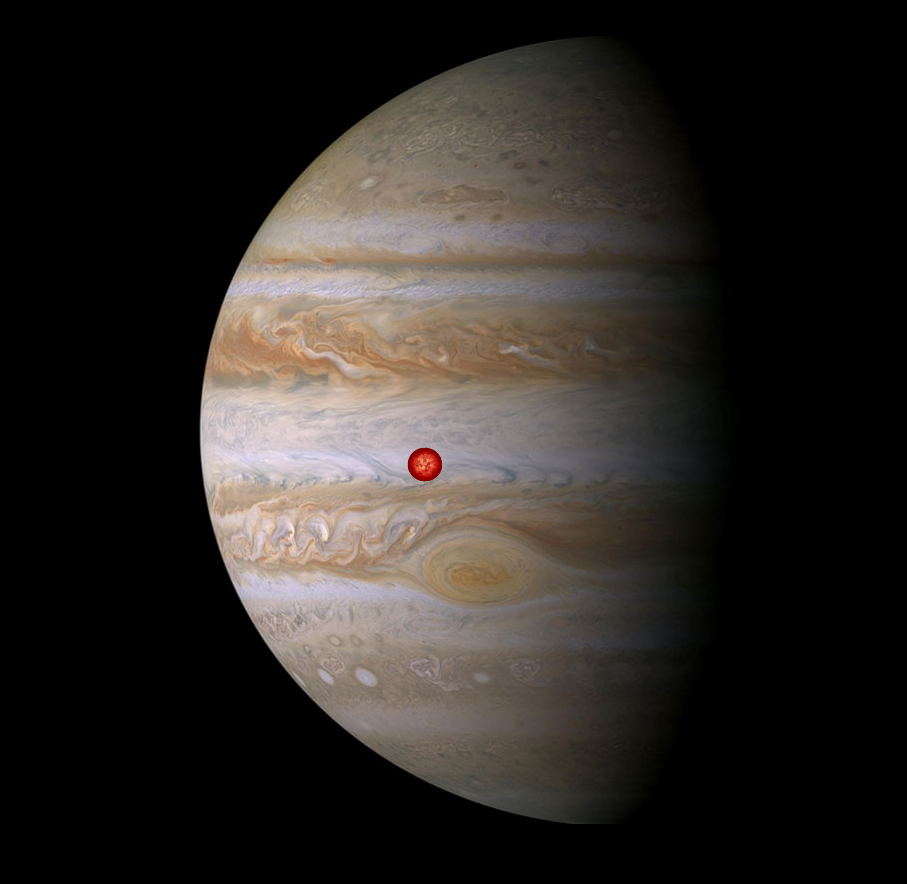

In [12]:
# For plot testing, plots the first frame only.
# Meant to be a check that everything looks as it should, before spending time generating the animation

import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path):
    return OffsetImage(plt.imread(path))


plt.style.use('dark_background')
# test init plot
zoom = 1e7
fig = plt.figure(figsize=(16,16))
# set up subplot grid
gridspec.GridSpec(3,3)
plt.set_cmap('OrRd')

# large subplot
ax = plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=3, projection='3d')
scatters = ax.scatter(states[0][:,0], states[0][:,1], states[0][:,2], s=ball_size/10000)#, c=distances)
#at = ax.scatter(-1.7e8, -0.6e8, -0.3e8, s=ball_size*18.5, alpha=0.8, facecolors='k', edgecolors='b', linewidths=3)#, c=distances)

# Add background image if wanted. Use path to your image
ab = AnnotationBbox(getImage(r'C:\Users\mikkel\Desktop\planet_sim\jupiter1.jpg'), (0, 0), frameon=False)
at = ax.add_artist(ab)
at.zorder = 0

# smaller subplots, make this code run to check that they work
"""
# small subplot 1
ax2 = plt.subplot2grid((2,3), (0,2))
vel_hist = ax2.hist(np.sqrt(states[0][:,3] ** 2 + states[0][:,4] ** 2 + states[0][:,5] ** 2) / dt , bins=np.linspace(0,1.5e6,51) / dt)
ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# small subplot 2
plt.subplot2grid((2,3), (1,2))
plt.hist(m * (states[0][:,3] ** 2 + states[0][:,4] ** 2 + states[0][:,5] ** 2), bins=np.linspace(0,1.2e32,51))
"""
# small subplot 3
#plt.subplot2grid((3,3), (2,2))
#plt.hist(np.sqrt(states[0][:,3] ** 2 + states[0][:,4] ** 2 + states[0][:,5] ** 2), bins=np.linspace(0,1.2e32,51))

#
#ax.view_init(elev=90, azim=0) # view x-y
#ax.view_init(elev=0, azim=0) # view y-z
#ax.view_init(elev=0, azim=90) # view x-z

scatters = ax.scatter(states[0][:,0], states[0][:,1], states[0][:,2], s=ball_size/10000, c=distances)

    
ax.view_init(elev=30, azim=30)
#ax.plot_surface(img_x * 5, img_y * 5, img_z, rstride=10, cstride=10, facecolors=img)
scatters = ax.scatter(states[0][:,0], states[0][:,1], states[0][:,2], s=ball_size/10000, c=distances)



# Setting the axes properties
ax.set_xlim3d(-4*zoom, 2*zoom)
ax.set_ylim3d(-3*zoom, 3*zoom)
ax.set_zlim3d(-3*zoom, 3*zoom)

ax.set_xlabel("x-coordinate",fontsize=14)
ax.set_ylabel("y-coordinate",fontsize=14)
ax.set_zlabel("z-coordinate",fontsize=14)
ax.axis('off')
# make the panes transparent
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))

# make the grid lines transparent
ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax.set_frame_on(True)



Done creating animation


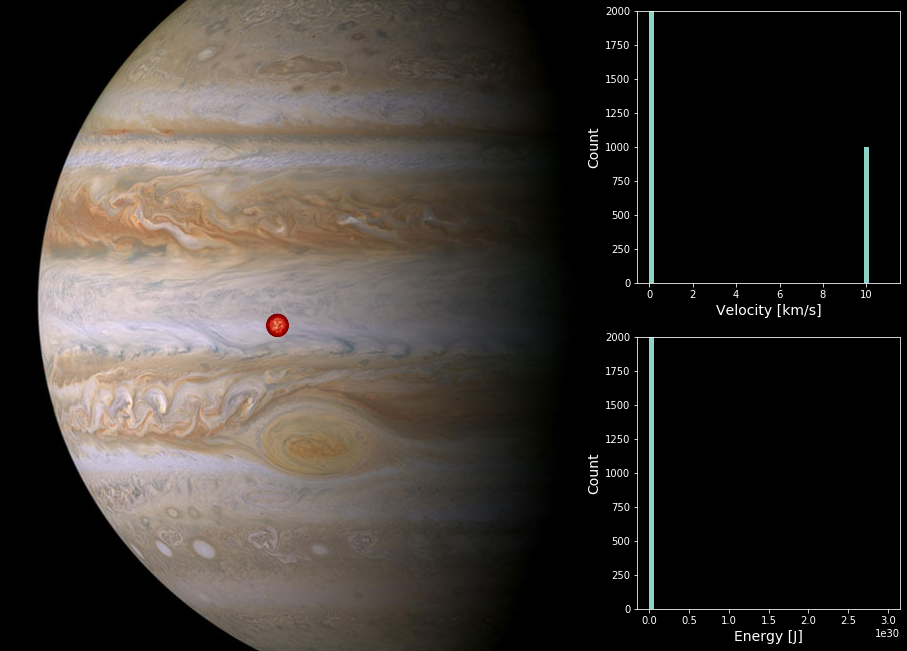

Wall time: 19min 45s


In [14]:
%%time
# Generate the animation

plt.style.use('dark_background')
from matplotlib import pyplot as plt
import numpy as np
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
from pylab import *
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cbook import get_sample_data
from matplotlib._png import read_png
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# Plots smaller graphs if True
plot_graphs = True

# Plots axes on animation if True
plot_axes = True

def getImage(path):
    return OffsetImage(plt.imread(path))

# test init plot
if plot_graphs:
    fig = plt.figure(figsize=(16,11))
else: 
    fig = plt.figure(figsize=(16,16))
    
# set up subplot grid
gridspec.GridSpec(3,3)

# large subplot
if plot_graphs:
    ax1 = plt.subplot2grid((2,3), (0,0), colspan=2, rowspan=2, projection='3d')
    size = ball_size*7.5
else: 
    ax1 = plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=3, projection='3d')
    size = ball_size*18.5
    
#at = ax1.scatter(-1.7e8, -0.6e8, -0.3e8, s=size, alpha=0.8, facecolors='k', edgecolors='b', linewidths=2)#, c=distances)#at = ax1.add_artist(ab)

ab = AnnotationBbox(getImage(r'C:\Users\mikkel\Desktop\planet_sim\jupiter1.jpg'), (0, 0), frameon=False)
at = ax1.add_artist(ab)
at.zorder = 0
scatters = ax1.scatter(states[0][:,0], states[0][:,1], states[0][:,2], s=ball_size/20000, c=distances, cmap='OrRd')

if plot_graphs:
    # small subplot 1
    ax2 = plt.subplot2grid((2,3), (0,2))
    vel_hist = ax2.hist(np.sqrt(states[0][:,3] ** 2 + states[0][:,4] ** 2 + states[0][:,5] ** 2) / dt / 1000., bins=np.linspace(0,20,51))
    ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))


    # small subplot 2
    ax3 = plt.subplot2grid((2,3), (1,2))
    e_hist = ax3.hist(m * (states[0][:,3] ** 2 + states[0][:,4] ** 2 + states[0][:,5] ** 2), bins=np.linspace(0,1.5e31,51))


def update(states):

    # update 3d plot
    scatters._offsets3d = (states[:,0], states[:,1], states[:,2])
    
    if plot_graphs:
        # update histograms
        ax2.cla()
        ax2.set_ylim(0, Ninit/5)
        vel_hist = ax2.hist(np.sqrt(states[:,3] ** 2 + states[:,4] ** 2 + states[:,5] ** 2) / dt / 1000., bins=np.linspace(0,11,51))
        ax2.set_xlabel("Velocity [km/s]",fontsize=14)
        ax2.set_ylabel("Count",fontsize=14)
        #ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

        ax3.cla()
        ax3.set_ylim(0, Ninit/5)
        e_hist = ax3.hist(m * (states[:,3] ** 2 + states[:,4] ** 2 + states[:,5] ** 2), bins=np.linspace(0,3e30,51))
        ax3.set_xlabel("Energy [J]",fontsize=14)
        ax3.set_ylabel("Count",fontsize=14)

    
    return scatters


#fn = get_sample_data(r'C:\Users\mikkel\Desktop\planet_sim\jupiterlarge.png', asfileobj=False)
#img = read_png(fn)

zoom = 1e7


ax1.view_init(elev=30, azim=30)

if not plot_axes:
    ax1.axis('off')

# Setting the axes properties
ax1.set_xlim3d(-4*zoom, 2*zoom)
ax1.set_ylim3d(-3*zoom, 3*zoom)
ax1.set_zlim3d(-3*zoom, 3*zoom)

ax1.set_xlabel("X [m]",fontsize=14)
ax1.set_ylabel("Y [m]",fontsize=14)
ax1.set_zlabel("Z [m]",fontsize=14)

# make the panes transparent
ax1.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax1.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax1.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax1.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax1.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

if plot_graphs:
    ax2.set_ylim(0,Ninit/5)
    ax2.set_xlabel("Velocity [m/s]",fontsize=14)
    ax2.set_ylabel("Count",fontsize=14)
    #ax2.ticklabel_format(style='sci')

    ax3.set_ylim(0,Ninit/5)
    ax3.set_xlabel("Energy [J]",fontsize=14)
    ax3.set_ylabel("Count",fontsize=14)

writer = animation.writers['ffmpeg'](fps=20)
ani = animation.FuncAnimation(fig, update, states, interval=50, blit=False)

if plot_graphs:
    save_name = 'IO_crash_%iparticles_%ioffset_%fcometRatio.mp4' %(Ninit, offset, moon_ratio)
else: 
    save_name = 'NoGraphs_IO_crash_%iparticles_%ioffset_%fcometRatio.mp4' %(Ninit, offset, moon_ratio)
    
ani.save(save_name, writer=writer)

print('Done creating animation')
plt.show()




Done creating animation


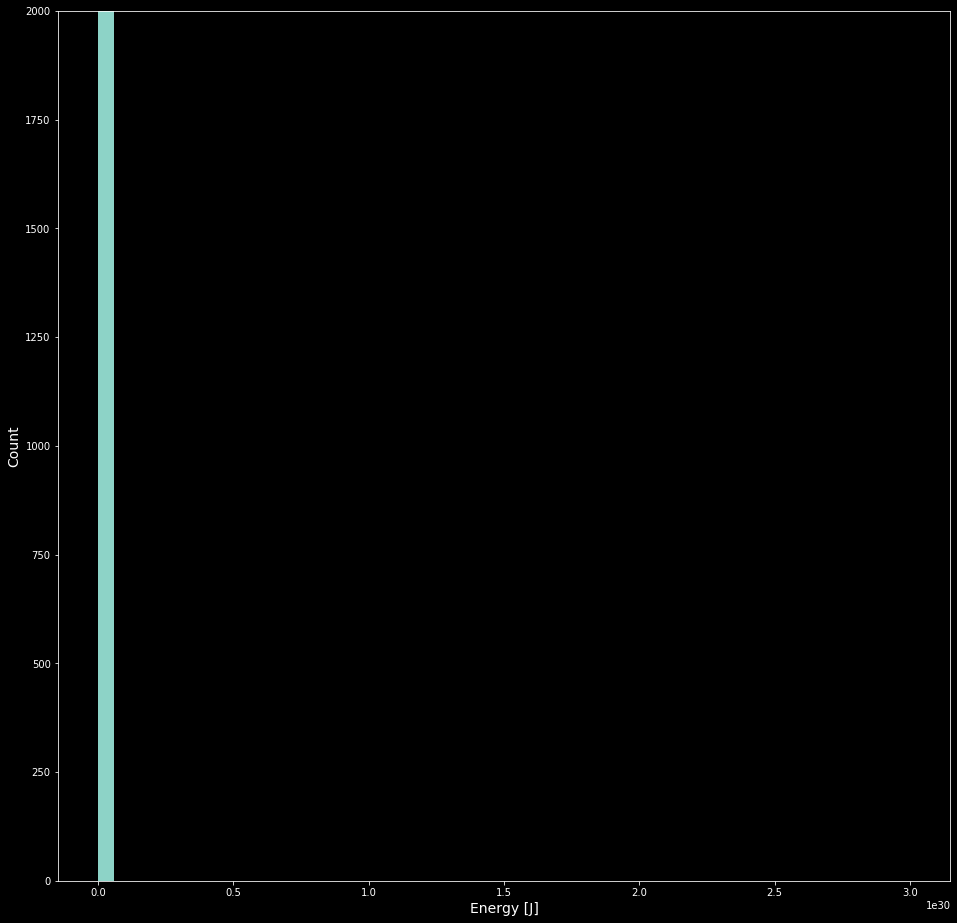

In [29]:
# Generate the smaller histograms as standalone, if wanted. Otherwise ignore this cell

def getImage(path):
    return OffsetImage(plt.imread(path))

plot_graphs = False
# test init plot
if plot_graphs:
    fig = plt.figure(figsize=(16,16))
else: 
    fig = plt.figure(figsize=(16,16))
    
# set up subplot grid
gridspec.GridSpec(3,3)


ax1 = plt.subplot2grid((3,3), (0,0), colspan=3, rowspan=3)
    


if plot_graphs:
    # small subplot 1
    #ax1 = plt.subplot2grid((3,3), (0,0))
    vel_hist = ax1.hist(np.sqrt(states[0][:,3] ** 2 + states[0][:,4] ** 2 + states[0][:,5] ** 2) / dt / 1000., bins=np.linspace(0,20,51))
    ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

else:
    # small subplot 2
    #ax1 = plt.subplot2grid((3,3), (0,0))
    e_hist = ax1.hist(m * (states[0][:,3] ** 2 + states[0][:,4] ** 2 + states[0][:,5] ** 2), bins=np.linspace(0,1.5e31,51))


def update(states):


    
    if plot_graphs:
        # update histograms
        ax1.cla()
        ax1.set_ylim(0, Ninit/5)
        vel_hist = ax1.hist(np.sqrt(states[:,3] ** 2 + states[:,4] ** 2 + states[:,5] ** 2) / dt / 1000., bins=np.linspace(0,11,51))
        ax1.set_xlabel("Velocity [km/s]",fontsize=14)
        ax1.set_ylabel("Count",fontsize=14)
        #ax2.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    else:
        ax1.cla()
        ax1.set_ylim(0, Ninit/5)
        e_hist = ax1.hist(m * (states[:,3] ** 2 + states[:,4] ** 2 + states[:,5] ** 2), bins=np.linspace(0,3e30,51))
        ax1.set_xlabel("Energy [J]",fontsize=14)
        ax1.set_ylabel("Count",fontsize=14)

    
    return scatters


if plot_graphs:
    ax1.set_ylim(0,Ninit/5)
    ax1.set_xlabel("Velocity [m/s]",fontsize=14)
    ax1.set_ylabel("Count",fontsize=14)
    #ax2.ticklabel_format(style='sci')
else:
    ax1.set_ylim(0,Ninit/5)
    ax1.set_xlabel("Energy [J]",fontsize=14)
    ax1.set_ylabel("Count",fontsize=14)

writer = animation.writers['ffmpeg'](fps=20)
ani = animation.FuncAnimation(fig, update, states, interval=50, blit=False)

if plot_graphs:
    save_name = 'graph1.mp4'
else: 
    save_name = 'graph2.mp4'
    
ani.save(save_name, writer=writer)

print('Done creating animation')
plt.show()

In [30]:
np.shape(states)

(500, 1100, 6)